In [1]:
library('bnlearn')
library(Rgraphviz);

Loading required package: graph

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:bnlearn’:

    score


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, wh

In [2]:
survey <- read.delim('survey.txt', sep = " ")
net <-  model2network("[A][S][E|A:S][O|E][R|E][T|O:R]")

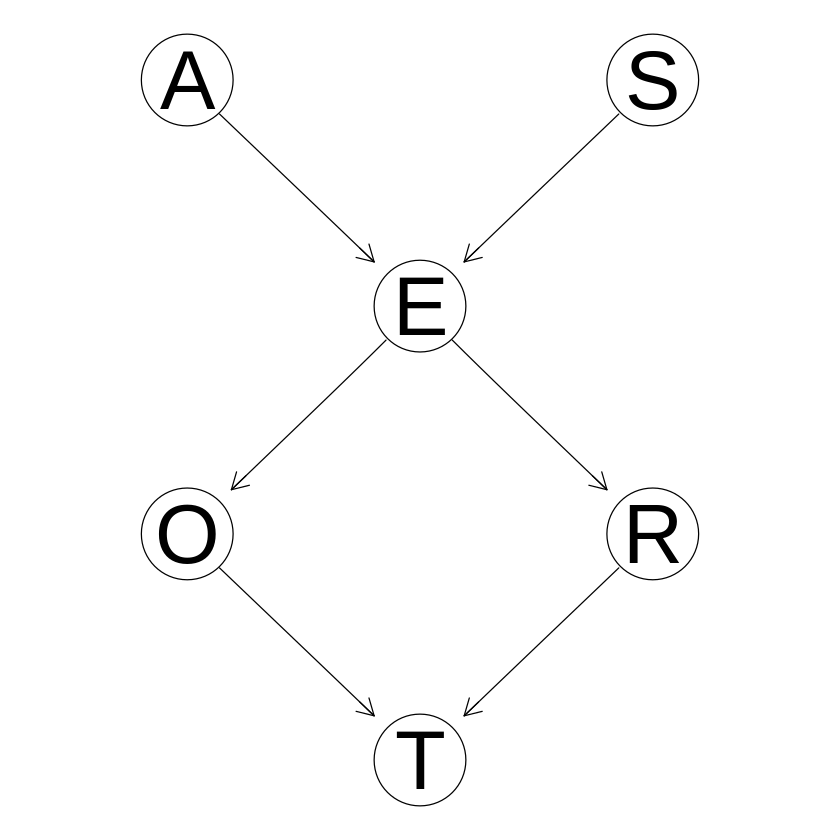

In [3]:
graphviz.plot(net)

In [4]:
d_sep <- bnlearn:::dseparation

In [5]:
d_sep(bn = net, x = 'A', y = 'E', z = c('R', 'T'))

[1] FALSE

In [6]:
vars <- nodes(net)
pairs <- combn(x = vars, 2, list)
arg_sets <- list()
for(pair in pairs){
  others <- setdiff(vars, pair)
  conditioning_sets <- unlist(lapply(0:4, function(.x) combn(others, .x, list)), recursive = F)
  for(set in conditioning_sets){
    args <- list(x = pair[1], y = pair[2], z = set)
    arg_sets <- c(arg_sets, list(args)) 
  }
}

In [7]:
d_separated_sets <- list()
for(i in 1:length(arg_sets)) {
    arg_set <- arg_sets[[i]]
  # i-th element of `u1` squared into `i`-th position of `usq`
        if( d_sep(bn=net, x=arg_set$x, y=arg_set$y, z=arg_set$z)){
            d_separated_sets <- c(d_separated_sets, list(arg_set)) 
        }
}

In [8]:
print(d_separated_sets[[12]])

$x
[1] "A"

$y
[1] "R"

$z
[1] "E" "T"



A and R  are causally independent of each other given E, T

1b. Redundant example : node1 d-separated from node2 given node3 => node1 d-separated from node2 given node3 + any of node3's children

In [10]:
redundant_sets <- list()
for(i in 1:(length(d_separated_sets) - 1)) {
    start_set <- d_separated_sets[[i]]
    if(length(start_set$z) == 1){
        for(j in (i+1):length(d_separated_sets)) {
            end_set <- d_separated_sets[[j]]
            if ((start_set$x == end_set$x) & (start_set$y == end_set$y)) {
                print(c(start_set$z, end_set$z))
            }
    #         print(c(start_set, end_set))
    #         print(setdiff(end_set$z , start_set$z))
    #         print(length(end_set))
    #         if((length(setdiff(end_set$z , start_set$z)) == 0) & (length(setdiff(start_set$z, end_set$z)) == 0) & (length(setdiff(end_set$x , start_set$y)) == 0) & (length(setdiff(start_set$y, end_set$x )) == 0)){
    #             redundant_sets <- c(redundant_sets, list(start_set), list(end_set))
    #             print('a')
    #             print(c(start_set, end_set))
    #         }
        }
    }
}

[1] "E" "E" "R"
[1] "E" "E" "S"
[1] "E" "E" "T"
[1] "E" "E" "R" "S"
[1] "E" "E" "R" "T"
[1] "E" "E" "S" "T"
[1] "E" "E" "R" "S" "T"
[1] "E" "E" "O"
[1] "E" "E" "S"
[1] "E" "E" "T"
[1] "E" "E" "O" "S"
[1] "E" "E" "O" "T"
[1] "E" "E" "S" "T"
[1] "E" "E" "O" "S" "T"
[1] "E" "E" "O"
[1] "E" "E" "R"
[1] "E" "E" "S"
[1] "E" "O" "R"
[1] "E" "E" "O" "R"
[1] "E" "E" "O" "S"
[1] "E" "E" "R" "S"
[1] "E" "O" "R" "S"
[1] "E" "E" "O" "R" "S"
[1] "E" "A" "E"
[1] "E" "E" "S"
[1] "E" "A" "E" "S"
[1] "E" "A" "E"
[1] "E" "E" "R"
[1] "E" "E" "T"
[1] "E" "A" "E" "R"
[1] "E" "A" "E" "T"
[1] "E" "E" "R" "T"
[1] "E" "A" "E" "R" "T"
[1] "E" "A" "E"
[1] "E" "E" "O"
[1] "E" "E" "T"
[1] "E" "A" "E" "O"
[1] "E" "A" "E" "T"
[1] "E" "E" "O" "T"
[1] "E" "A" "E" "O" "T"
[1] "E" "A" "E"
[1] "E" "E" "O"
[1] "E" "E" "R"
[1] "E" "O" "R"
[1] "E" "A" "E" "O"
[1] "E" "A" "E" "R"
[1] "E" "A" "O" "R"
[1] "E" "E" "O" "R"
[1] "E" "A" "E" "O" "R"


1e

In [19]:

for( d_sep_set in d_separated_sets){
    test_outcome <- ci.test(d_sep_set$x, d_sep_set$y,d_sep_set$z, survey)
    if(test_outcome$p.value < 0.05) {
        print("Markov test")
        print(d_sep_set)
    }
}

[1] "Markov test"
$x
[1] "A"

$y
[1] "O"

$z
[1] "E" "S"

[1] "Markov test"
$x
[1] "A"

$y
[1] "R"

$z
[1] "E" "O"

[1] "Markov test"
$x
[1] "O"

$y
[1] "S"

$z
[1] "A" "E"

[1] "Markov test"
$x
[1] "O"

$y
[1] "S"

$z
[1] "E" "T"

[1] "Markov test"
$x
[1] "S"

$y
[1] "T"

$z
[1] "E" "O"



2a)

In [ ]:
net <- model2network('[A][S][E|A:S][O|E]')
nombres <- c('off', 'on')
cptA <- matrix(c(0.5, 0.5), ncol=2)
dimnames(cptA) <- list(NULL, nombres)
cptB <- matrix(c(.8, .2, .1, .9), ncol=2)
dimnames(cptB) <- list(B = nombres, A = nombres)
cptC <- matrix(c(.9, .1, .99, .01, .1, .9, .4, .6))
dim(cptC) <- c(2, 2, 2)
dimnames(cptC) <- list(C = nombres, A = nombres, B = nombres)
model <- custom.fit(net, list(A = cptA, B = cptB, C = cptC))


In [5]:
net <- model2network('[A][B|A][C|B:A]')
nombres <- c('off', 'on')
cptA <- matrix(c(0.5, 0.5), ncol=2)
dimnames(cptA) <- list(NULL, nombres)
cptB <- matrix(c(.8, .2, .1, .9), ncol=2)
dimnames(cptB) <- list(B = nombres, A = nombres)
cptC <- matrix(c(.9, .1, .99, .01, .1, .9, .4, .6))
dim(cptC) <- c(2, 2, 2)
dimnames(cptC) <- list(C = nombres, A = nombres, B = nombres)
model <- custom.fit(net, list(A = cptA, B = cptB, C = cptC))


In [8]:
?rbn